In [12]:
!pip install git+https://github.com/fagonzalezo/kdm.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/fagonzalezo/kdm.git to c:\users\user\appdata\local\temp\pip-req-build-g90z5hv4
  Resolved https://github.com/fagonzalezo/kdm.git to commit 7b8bc9f338975c03ede87c6efecc36b75c23ddf8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/fagonzalezo/kdm.git 'C:\Users\user\AppData\Local\Temp\pip-req-build-g90z5hv4'

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
import keras
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    explained_variance_score,
    max_error
)
from sklearn.datasets import load_diabetes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import kdm
from kdm.models import KDMRegressModel
from kdm.utils import dm_rbf_expectation, dm_rbf_variance, dm_rbf_loglik, dm2comp


In [14]:
# Load and prepare data
X, y = load_diabetes(return_X_y=True)
y = y.astype(float).reshape(-1, 1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale data
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = MinMaxScaler((0.2, 0.8))
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Instantiate a Gaussian Process model as baseline
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.01, n_restarts_optimizer=10)


In [15]:
def train_kdm_model(n_comp=50, generative=False, epochs=100):
    encoded_size = X_train.shape[1]
    dim_y = 1
    encoder = keras.Sequential([keras.layers.Identity()])

    kdm_model = KDMRegressModel(
        encoded_size=encoded_size,
        dim_y=dim_y,
        encoder=encoder,
        n_comp=n_comp,
        sigma_x=0.1,
        sigma_y=0.1,
        generative=generative
    )

    # Compile model
    kdm_model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=None
    )

    # Initialize components
    idx = np.random.randint(X_train.shape[0], size=n_comp)
    kdm_model.init_components(X_train[idx], y_train[idx], init_sigma=True)

    # Training and tracking
    losses = []
    sigma_x = []
    sigma_y = []

    for i in range(epochs):
        history = kdm_model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
        losses.append(history.history['loss'][0])
        sigma_x.append(keras.ops.convert_to_numpy(kdm_model.kernel.sigma))
        sigma_y.append(keras.ops.convert_to_numpy(kdm_model.sigma_y))

    # Visualize training metrics
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.plot(losses)
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")

    plt.subplot(132)
    plt.plot(sigma_x)
    plt.title("Sigma X")
    plt.xlabel("Epoch")
    plt.ylabel("Sigma X Value")

    plt.subplot(133)
    plt.plot(sigma_y)
    plt.title("Sigma Y")
    plt.xlabel("Epoch")
    plt.ylabel("Sigma Y Value")

    plt.tight_layout()
    plt.show()

    return kdm_model

In [16]:
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics using scikit-learn"""
    metrics = {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'Explained Variance': explained_variance_score(y_true, y_pred),
        'Max Error': max_error(y_true, y_pred)
    }
    return metrics

In [17]:

def evaluate_model(kdm_model):
    # Get predictions and uncertainty
    rho_y = kdm_model.predict(X_test)
    y_pred = keras.ops.convert_to_numpy(dm_rbf_expectation(rho_y)).flatten()
    y_var = keras.ops.convert_to_numpy(dm_rbf_variance(rho_y, kdm_model.sigma_y))

    # Calculate comprehensive metrics
    metrics = calculate_metrics(y_test, y_pred.reshape(-1, 1))
    
    # Print metrics
    print("\nModel Performance Metrics:")
    print("-" * 30)
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("-" * 30)
    print(f"X_sigma: {keras.ops.convert_to_numpy(kdm_model.kernel.sigma) / np.sqrt(2):.4f}")
    print(f"Y_sigma: {keras.ops.convert_to_numpy(kdm_model.sigma_y) / np.sqrt(2):.4f}")
    print(f"Avg prediction variance: {np.mean(y_var):.4f}")

    # Visualize predictions vs real values with confidence intervals
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, 'r.', label='Real Values', alpha=0.5)
    plt.plot(y_pred, 'b-', label='Predictions')
    
    stddev = y_var ** 0.5
    plt.fill_between(range(len(y_test)), 
                    y_pred - 1.96 * stddev, 
                    y_pred + 1.96 * stddev,
                    alpha=0.5, fc='b', ec='None', 
                    label='95% confidence interval')

    plt.legend()
    plt.title('Predictions vs Real Values with Confidence Intervals')
    plt.xlabel('Sample Index')
    plt.ylabel('Target Value')
    plt.show()

    # Visualize residuals
    residuals = y_test.flatten() - y_pred
    plt.figure(figsize=(10, 4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

    # Visualize model components
    plt.figure(figsize=(8, 4))
    c_x = keras.ops.convert_to_numpy(kdm_model.kdm.c_x)
    c_y = keras.ops.convert_to_numpy(kdm_model.kdm.c_y)
    c_w = keras.ops.convert_to_numpy(kdm_model.kdm.c_w)
    c_w = np.abs(c_w) / np.sum(np.abs(c_w))

    plt.scatter(range(len(c_w)), c_w, alpha=0.5)
    plt.title("KDM Component Weights")
    plt.xlabel('Component Index')
    plt.ylabel('Normalized Weight')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.show()

In [18]:
def plot_density(kdm_model, feature_idx, value):
    """Plot the predicted probability density for a specific feature value"""
    # Create input point with mean values except for specified feature
    x_point = np.mean(X_test, axis=0)
    x_point[feature_idx] = value
    x_point = x_point.reshape(1, -1)
    
    # Get prediction density
    rho_y = keras.ops.cast(kdm_model(x_point), dtype='float32')
    
    # Create range of possible y values
    y_range = np.linspace(0, 1, 1000).reshape(-1, 1)
    
    # Calculate likelihood
    loglik = dm_rbf_loglik(
        keras.ops.convert_to_tensor(y_range, dtype="float32"),
        rho_y,
        kdm_model.sigma_y
    )
    lik = keras.ops.convert_to_numpy(keras.ops.exp(loglik))
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_range, lik)
    plt.title(f"Predicted probability density for feature {feature_idx} = {value:.2f}")
    plt.xlabel('Target Value')
    plt.ylabel('Density')
    plt.show()

Training discriminative KDM model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


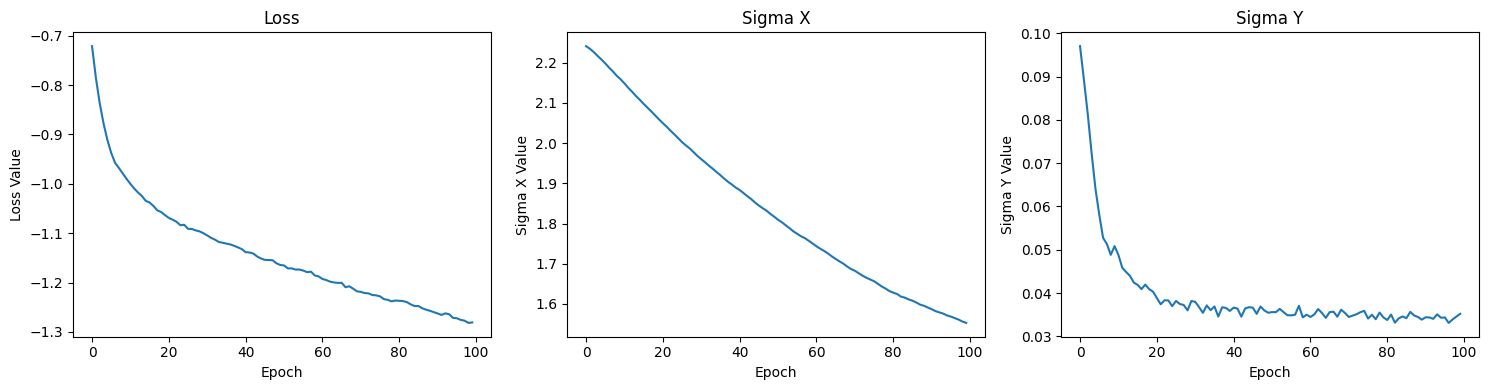


Evaluating discriminative KDM model:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Model Performance Metrics:
------------------------------
MSE: 0.0103
RMSE: 0.1014
MAE: 0.0787
R²: 0.4546
Explained Variance: 0.4550
Max Error: 0.2922
------------------------------
X_sigma: 1.0979
Y_sigma: 0.0249
Avg prediction variance: 0.0102


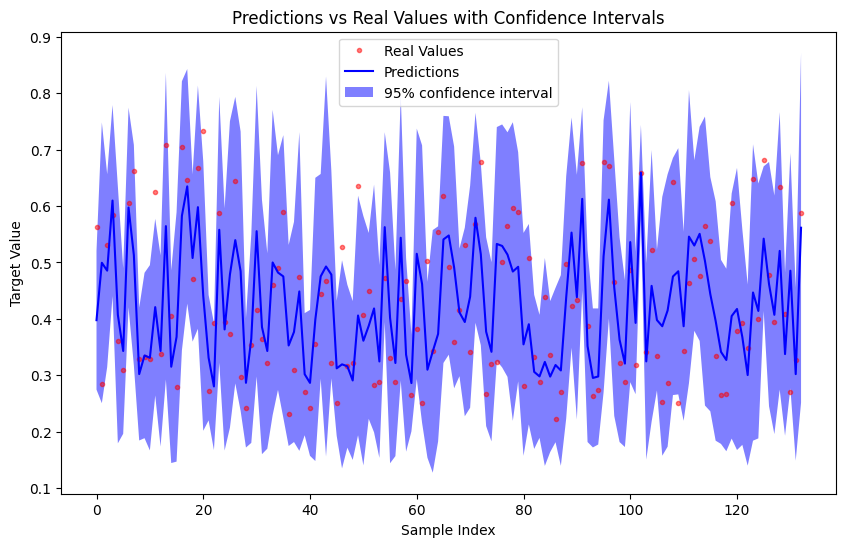

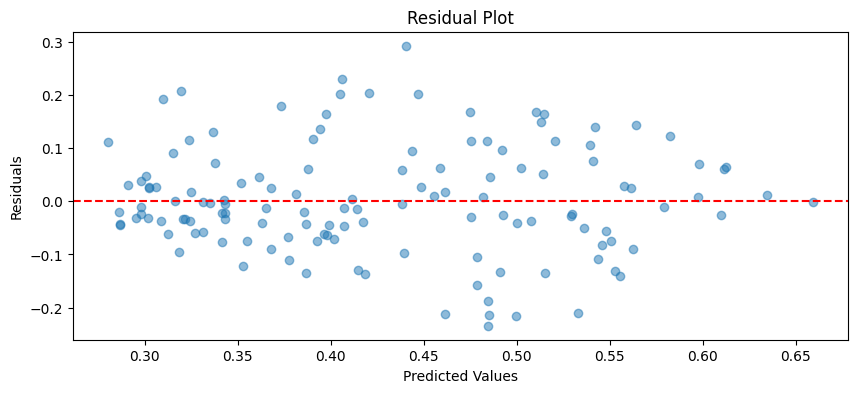

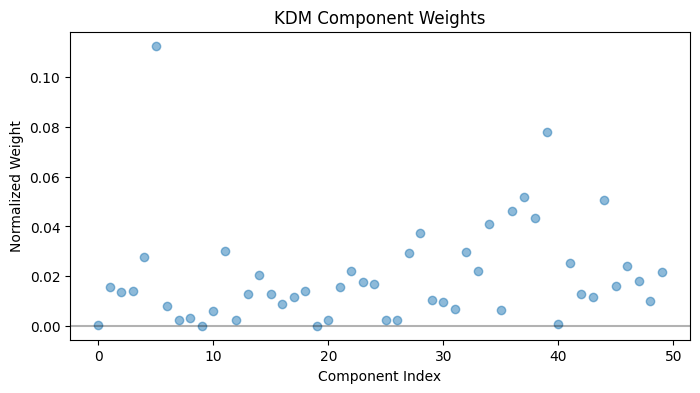

In [19]:
# Train and evaluate discriminative model
print("Training discriminative KDM model...")
kdm_disc_model = train_kdm_model(n_comp=50, generative=False, epochs=100)
print("\nEvaluating discriminative KDM model:")
evaluate_model(kdm_disc_model)


Training generative KDM model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


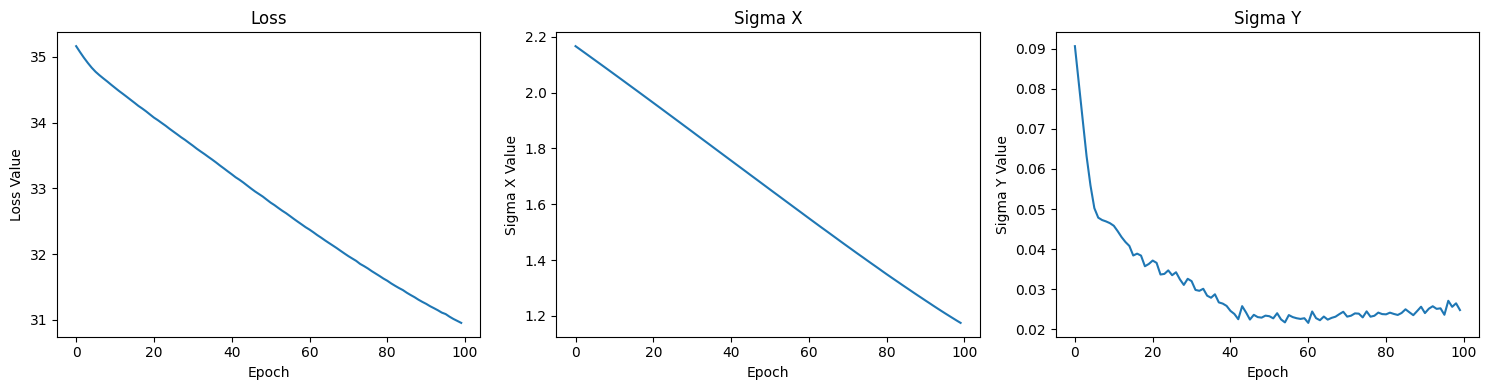


Evaluating generative KDM model:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Model Performance Metrics:
------------------------------
MSE: 0.0098
RMSE: 0.0991
MAE: 0.0781
R²: 0.4790
Explained Variance: 0.4829
Max Error: 0.2994
------------------------------
X_sigma: 0.8306
Y_sigma: 0.0175
Avg prediction variance: 0.0094


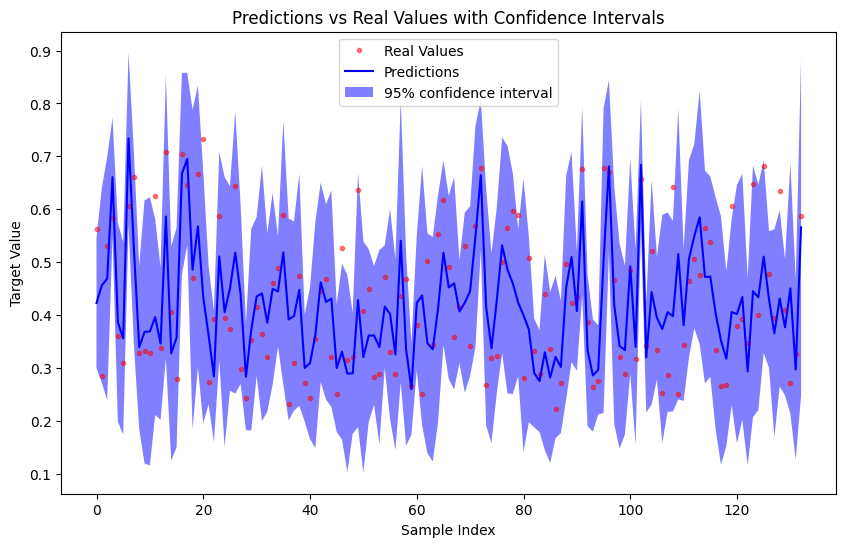

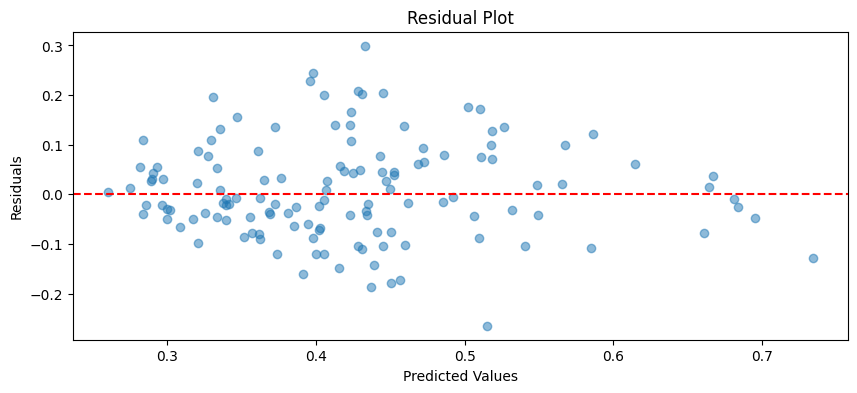

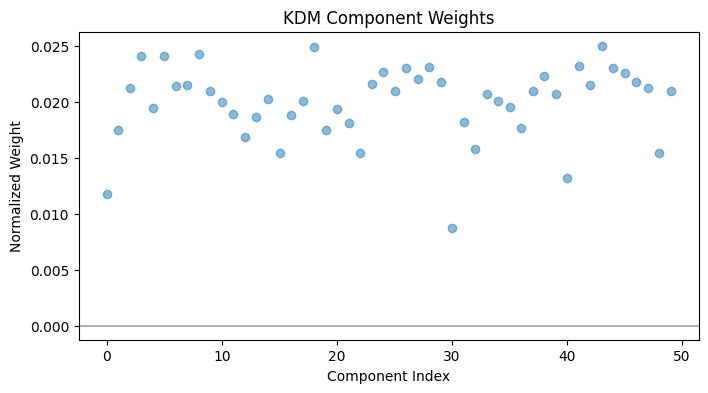

In [20]:
# Train and evaluate generative model
print("\nTraining generative KDM model...")
kdm_gen_model = train_kdm_model(n_comp=50, generative=True, epochs=100)
print("\nEvaluating generative KDM model:")
evaluate_model(kdm_gen_model)


In [21]:
# Compare with baseline GP model
print("\nTraining and evaluating Gaussian Process baseline model...")
gp.fit(X_train, y_train)
y_pred_gp = gp.predict(X_test)
gp_metrics = calculate_metrics(y_test, y_pred_gp)
print("\nGaussian Process Model Performance Metrics:")
print("-" * 30)
for metric_name, value in gp_metrics.items():
    print(f"{metric_name}: {value:.4f}")



Training and evaluating Gaussian Process baseline model...

Gaussian Process Model Performance Metrics:
------------------------------
MSE: 0.0097
RMSE: 0.0986
MAE: 0.0778
R²: 0.4848
Explained Variance: 0.4874
Max Error: 0.2747
